In [1]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [7]:
# %load multi_bike.py
import math
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from matplotlib import pyplot as plt
from matplotlib import cm
from datetime import datetime

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10

df = pd.read_csv('./data/bike_train.csv')

df.columns


def get_days_of_year(date):
    date = datetime.strptime(date, "%Y-%m-%d %H:%M:%S")
    new_year_day = datetime(year=date.year, month=1, day=1)
    return (date - new_year_day).days + 1


df['day_of_year'] = df['datetime'].apply(get_days_of_year)
df['hour'] = df['datetime'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").hour)
df['workday'] = df['datetime'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").weekday())

df.describe()
# 1. Define features and Define target
# - define featureas and configure feature columnsA
# - define target
# - define input function


def train_model(learning_rate, steps, batch_size, periods, input_features=['hour']):
    # learning_rate = 1e-4
    # steps = 100
    # batch_size = 100
    # periods = 3
    # input_features = ['hour', 'atemp']
    steps_per_period = int(steps / periods)
    print('learning_rate', learning_rate)
    print('steps', steps)
    print('steps_per_period', steps_per_period)
    feature_columns = [tf.feature_column.numeric_column(column) for column in input_features]
    X_train = df[input_features]
    target_feature = 'count'
    y_train = df[target_feature]

    def input_fn(X_data, y_data, batch_size=1, repeat=None, shuffle=False):
        X_tensors = {key: np.array(value) for key, value in dict(X_data).items()}
        ds = tf.data.Dataset.from_tensor_slices((X_tensors, y_data))
        ds = ds.batch(int(batch_size)).repeat(repeat)
        if shuffle:
            ds.shuffle(buffer_size=10000)
        X, y = ds.make_one_shot_iterator().get_next()
        return X, y
    # input_fn(X_train, y_train)

    # 2. Define Model
    # - Configure optimizer
    # - Confiture algorithmn
    # - Train the model

    train_input_fn = lambda: input_fn(X_train, y_train, batch_size=batch_size, repeat=100, shuffle=True)
    predict_input_fn = lambda: input_fn(X_train, y_train, batch_size=batch_size, repeat=1, shuffle=False)

    gdo = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    gdo = tf.contrib.estimator.clip_gradients_by_norm(gdo, 5.0)

    linear_regressor = tf.estimator.LinearRegressor(feature_columns=feature_columns, optimizer=gdo)

    input_feature_num = len(input_features)
    print('input_feature_num', input_feature_num)
    rows = math.ceil(math.sqrt(input_feature_num))
    columns = math.ceil(math.sqrt(input_feature_num))

    plt.figure(figsize=(15, 10))
    colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

    for i in range(input_feature_num):
        x_feature = input_features[i]
        plt.subplot(rows, columns, i + 1)
        plt.ylabel(target_feature)
        plt.xlabel(x_feature)
        sample = df.sample(n=300)
        plt.scatter(sample[x_feature], sample[target_feature])

    root_mean_squared_errors = []
    for period in range(periods):
        linear_regressor.train(input_fn=train_input_fn, steps=steps_per_period)
        predictions = linear_regressor.predict(input_fn=predict_input_fn)
        predictions = [item['predictions'][0] for item in predictions]
        mean_squared_error = metrics.mean_squared_error(predictions, y_train)
        root_mean_squared_error = math.sqrt(mean_squared_error)
        root_mean_squared_errors.append(root_mean_squared_error)
        print('period: %02d: %0.2f' % (period, root_mean_squared_error))

        for i in range(input_feature_num):
            x_feature = input_features[i]
            plt.subplot(rows, columns, i + 1)
            weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % x_feature)[0][0]
            bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')[0]
            x_min = sample[x_feature].min()
            x_max = sample[x_feature].max()
            y_min = x_min * weight + bias
            y_max = x_max * weight + bias
            plt.plot([x_min, x_max], [y_min, y_max], c=colors[period])

    # 3. Evalute the Model
    # - Predict
    # - Measure score
    print("RMSE: on traning %0.2f" % root_mean_squared_error)
    result_df = pd.DataFrame({'perdiction': pd.Series(predictions)})
    for key, value in dict(df[input_features]).items():
        result_df[key] = value

    print(result_df.describe())
    print("RMSE: on traning %0.2f" % root_mean_squared_error) 

    plt.subplot(rows, columns, input_feature_num + 1)
    print(rows, columns, input_feature_num + 1)
    plt.ylabel('RMSE')
    plt.xlabel('Periods')

    plt.plot(np.arange(len(root_mean_squared_errors)), root_mean_squared_errors)
    plt.show()


if __name__ == '__main__':
    def is_interactive():
        import __main__ as main
        return not hasattr(main, '__file__')

    if not is_interactive():
        train_model(
                learning_rate=1e-4,
                steps=100,
                batch_size=100,
                periods=3,
                input_features=['hour', 'atemp'])


learning_rate 0.0001
steps 1000000.0
steps_per_period 100000
input_feature_num 1
period: 00: 213.84


/Users/younlee/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


period: 01: 185.54
period: 02: 174.28
period: 03: 170.85
period: 04: 169.79
period: 05: 169.62
period: 06: 169.59
period: 07: 169.56
period: 08: 169.52
period: 09: 169.48
RMSE: on traning 169.48
       perdiction    hour
count     10886.0 10886.0
mean        177.1    11.5
std         103.7     6.9
min           4.1     0.0
25%          94.0     6.0
50%         183.9    12.0
75%         273.9    18.0
max         348.8    23.0
RMSE: on traning 169.48


ValueError: num must be 1 <= num <= 1, not 2

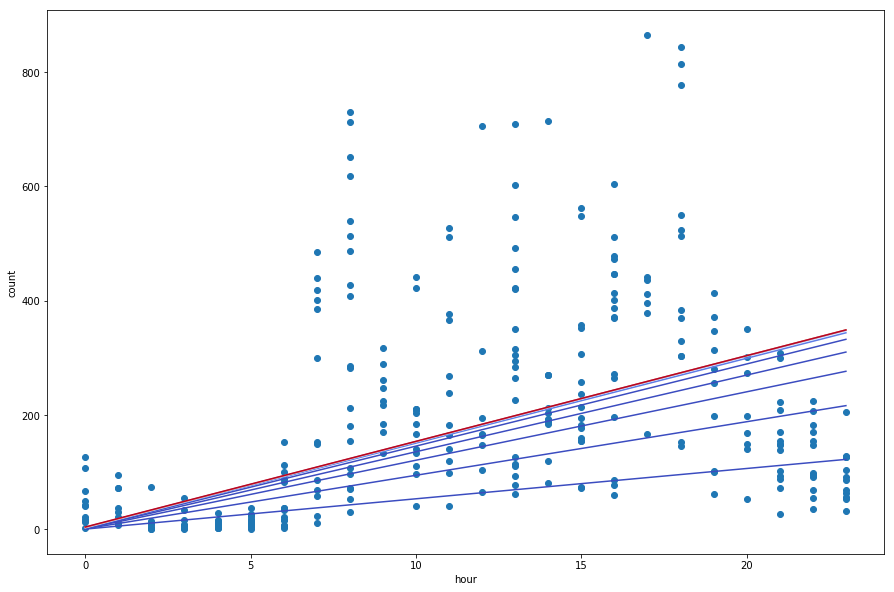

In [8]:
train_model(
        learning_rate=1e-4,
        steps=1e+6,
        batch_size=1e+2,
        periods=10,
        input_features=['hour'])

learning_rate 0.0001
steps 1000000.0
steps_per_period 100000
input_feature_num 2
period: 00: 174.52


/Users/younlee/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


period: 01: 159.11
period: 02: 157.88
period: 03: 157.60
period: 04: 157.46
period: 05: 157.40
period: 06: 157.35
period: 07: 157.31
period: 08: 157.28
period: 09: 157.26
RMSE: on traning 157.26
       perdiction    hour   atemp
count     10886.0 10886.0 10886.0
mean        187.1    11.5    23.7
std          65.8     6.9     8.5
min          13.3     0.0     0.8
25%         136.6     6.0    16.7
50%         188.5    12.0    24.2
75%         240.3    18.0    31.1
max         345.2    23.0    45.5
RMSE: on traning 157.26
2 2 3


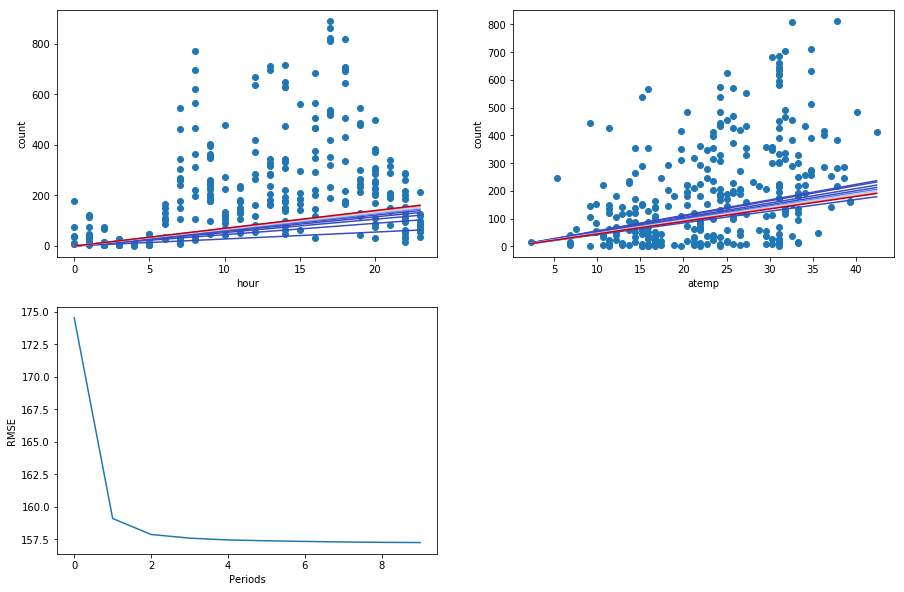

In [9]:
train_model(
        learning_rate=1e-4,
        steps=1e+6,
        batch_size=1e+2,
        periods=10,
        input_features=['hour', 'atemp'])

learning_rate 0.0001
steps 1000000.0
steps_per_period 100000
input_feature_num 11
period: 00: 183.52


/Users/younlee/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


period: 01: 174.55
period: 02: 167.74
period: 03: 163.01
period: 04: 159.82
period: 05: 157.42
period: 06: 155.63
period: 07: 154.21
period: 08: 153.04
period: 09: 152.16
RMSE: on traning 152.16
       perdiction  season  holiday  workingday  weather    temp   atemp  \
count     10886.0 10886.0  10886.0     10886.0  10886.0 10886.0 10886.0   
mean        188.9     2.5      0.0         0.7      1.4    20.2    23.7   
std          85.3     1.1      0.2         0.5      0.6     7.8     8.5   
min         -46.8     1.0      0.0         0.0      1.0     0.8     0.8   
25%         130.3     2.0      0.0         0.0      1.0    13.9    16.7   
50%         193.4     3.0      0.0         1.0      1.0    20.5    24.2   
75%         254.9     4.0      0.0         1.0      2.0    26.2    31.1   
max         387.2     4.0      1.0         1.0      4.0    41.0    45.5   

       humidity  windspeed  day_of_year    hour  workday  
count   10886.0    10886.0      10886.0 10886.0  10886.0  
mean       

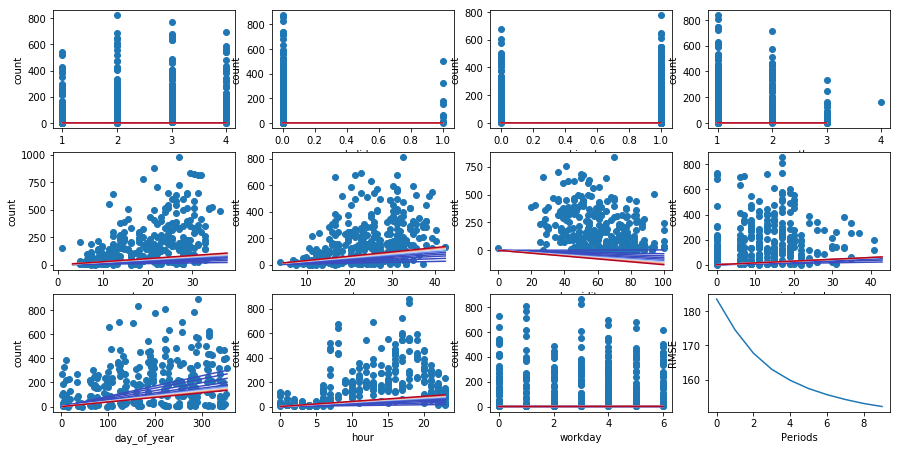

In [22]:
train_model(
        learning_rate=1e-4,
        steps=1e+6,
        batch_size=1e+2,
        periods=10,
        input_features=['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'day_of_year', 'hour', 'workday'])
  

learning_rate 0.0001
steps 1000000.0
steps_per_period 1000
input_feature_num 11
period: 00: 207.41


/Users/younlee/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


period: 01: 189.43
period: 02: 188.00
period: 03: 188.66
period: 04: 188.55
period: 05: 187.84
period: 06: 186.96
period: 07: 186.05
period: 08: 185.13
period: 09: 184.22
period: 10: 183.32
period: 11: 182.43
period: 12: 181.54
period: 13: 180.66
period: 14: 179.78
period: 15: 178.91
period: 16: 178.05
period: 17: 177.22
period: 18: 176.43
period: 19: 175.66
period: 20: 174.93
period: 21: 174.21
period: 22: 173.51
period: 23: 172.83
period: 24: 172.16
period: 25: 171.51
period: 26: 170.88
period: 27: 170.28
period: 28: 169.70
period: 29: 169.12
period: 30: 168.54
period: 31: 167.97
period: 32: 167.40
period: 33: 166.85
period: 34: 166.35
period: 35: 165.88
period: 36: 165.44
period: 37: 165.02
period: 38: 164.63
period: 39: 164.25
period: 40: 163.89
period: 41: 163.54
period: 42: 163.20
period: 43: 162.87
period: 44: 162.54
period: 45: 162.22
period: 46: 161.91
period: 47: 161.62
period: 48: 161.33
period: 49: 161.06
period: 50: 160.79
period: 51: 160.53
period: 52: 160.27
period: 53: 

period: 416: 149.43
period: 417: 149.43
period: 418: 149.43
period: 419: 149.43
period: 420: 149.43
period: 421: 149.42
period: 422: 149.42
period: 423: 149.42
period: 424: 149.42
period: 425: 149.42
period: 426: 149.42
period: 427: 149.42
period: 428: 149.42
period: 429: 149.41
period: 430: 149.41
period: 431: 149.41
period: 432: 149.41
period: 433: 149.41
period: 434: 149.41
period: 435: 149.41
period: 436: 149.41
period: 437: 149.41
period: 438: 149.40
period: 439: 149.40
period: 440: 149.40
period: 441: 149.40
period: 442: 149.40
period: 443: 149.40
period: 444: 149.40
period: 445: 149.40
period: 446: 149.40
period: 447: 149.39
period: 448: 149.39
period: 449: 149.39
period: 450: 149.39
period: 451: 149.39
period: 452: 149.39
period: 453: 149.39
period: 454: 149.39
period: 455: 149.39
period: 456: 149.39
period: 457: 149.39
period: 458: 149.38
period: 459: 149.38
period: 460: 149.38
period: 461: 149.38
period: 462: 149.38
period: 463: 149.38
period: 464: 149.38
period: 465: 149.38


period: 826: 149.21
period: 827: 149.21
period: 828: 149.21
period: 829: 149.21
period: 830: 149.21
period: 831: 149.21
period: 832: 149.21
period: 833: 149.21
period: 834: 149.21
period: 835: 149.21
period: 836: 149.21
period: 837: 149.21
period: 838: 149.21
period: 839: 149.21
period: 840: 149.21
period: 841: 149.21
period: 842: 149.21
period: 843: 149.21
period: 844: 149.21
period: 845: 149.21
period: 846: 149.21
period: 847: 149.21
period: 848: 149.21
period: 849: 149.21
period: 850: 149.21
period: 851: 149.21
period: 852: 149.21
period: 853: 149.21
period: 854: 149.21
period: 855: 149.21
period: 856: 149.21
period: 857: 149.21
period: 858: 149.21
period: 859: 149.21
period: 860: 149.21
period: 861: 149.21
period: 862: 149.21
period: 863: 149.21
period: 864: 149.21
period: 865: 149.21
period: 866: 149.21
period: 867: 149.21
period: 868: 149.21
period: 869: 149.21
period: 870: 149.21
period: 871: 149.21
period: 872: 149.21
period: 873: 149.21
period: 874: 149.21
period: 875: 149.21


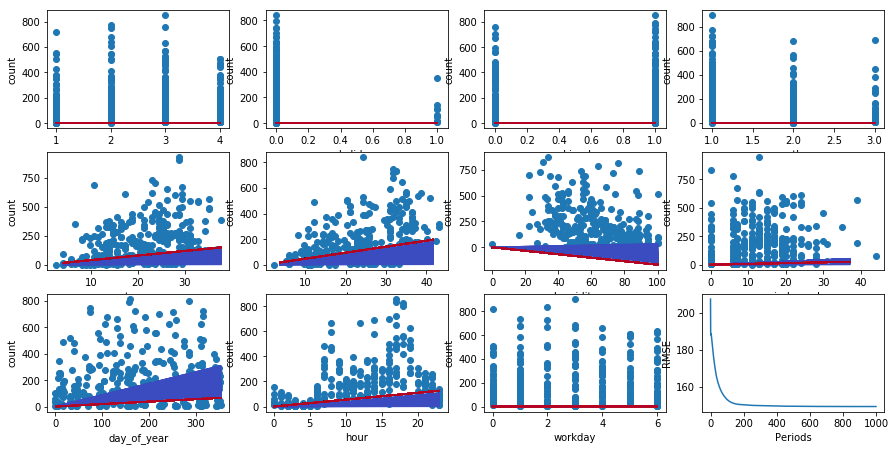

In [23]:
train_model(
        learning_rate=1e-4,
        steps=1e+6,
        batch_size=1e+2,
        periods=1000,
        input_features=['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'day_of_year', 'hour', 'workday'])